In [1]:
# Author: Alden Sahi
# Project Name: EarningsReportJunkie
# Project Description:
  # User specifies stock
  # Returns Predicted Capital Gain using disparity of stock price that predicted earnings
  # suggests vs reported earnings

# Model needs: predicted stock price at the data of earnings, predicted earnings, and the last pe ratio from last earnings
# THis means wee nee

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta

In [3]:
# User Input
ticker='IBM'
alpha_key = 'TQCF34ZIGZ7OTPLO'
train_data_start = '1996-03-31'
train_data_end = '2024-12-31'

## Getting Data

In [4]:
#  Gets all fundamental data from 

def get_data(ticker, alpha_key) :
    # earnings data
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={alpha_key}'
    r = requests.get(url)
    data = r.json()

    if 'quarterlyEarnings' not in data:
        raise ValueError(f"Failed to fetch earnings data for {ticker}. Check your API key or ticker symbol.")
    earnings_data = pd.DataFrame(data['quarterlyEarnings'])
    
    # cash flow data
    url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={alpha_key}]'
    r = requests.get(url)
    data = r.json()
    cash_flow_data = pd.DataFrame(data['quarterlyReports'])
    
    # balance sheet data 
    url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={alpha_key}'
    r = requests.get(url)
    data = r.json()
    balance_sheet_data = pd.DataFrame(data['quarterlyReports'])
    
    # income statment data
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={alpha_key}'
    r = requests.get(url)
    data = r.json()
    income_stmt_data = pd.DataFrame(data['quarterlyReports'])
    
    # prices api
    #prices = yf.download(ticker, start=train_data_start, end=train_data_end)
    
    total_report = earnings_data.merge(cash_flow_data, on='fiscalDateEnding') \
                           .merge(income_stmt_data, on='fiscalDateEnding') \
                           .merge(balance_sheet_data, on='fiscalDateEnding')
                           
    return total_report


In [ ]:
data = get_data(ticker=ticker, alpha_key=alpha_key)
data

In [ ]:
#joins into single index (was multtIndex)
#prices.columns = ['_'.join(col) for col in prices.columns]
# Create a new column from the index so we can merge easy with total_report
#prices['fiscalDateEnding'] = prices.index

# Convert 'fiscalDateEnding' to datetime64[ns]
#total_report['fiscalDateEnding'] = pd.to_datetime(total_report['fiscalDateEnding'])

[*********************100%***********************]  1 of 1 completed


## Merging and Filtering Data

In [57]:
## MORE ACCURATE TBT

# makes new row with dates for


# Create a new column in prices for output
#prices['Aligned_Price'] = None

# for every row in total_report
#for idx, row in total_report.iterrows():
    # if the corresponding rows' report time is premarket
    #if total_report['reportTime_x'][idx] == 'pre-market':
        # save open price to the prices with that idx
       # prices.loc[date] = 1
    # if the corresponding rows' report time is postmarket
    #if total_report['reportTime_x'][idx] == 'poste-market':
        # save the open price of the next day
          #prices.loc[date] = 0
        

    

In [59]:
prices = prices[[f'Open_{ticker}','fiscalDateEnding']]

In [60]:
# prices 
prices[f'Next_Day_{ticker}'] = prices[f'Open_{ticker}'].shift(-1)

In [61]:
total_report = total_report.merge(prices,on=['fiscalDateEnding'])

In [62]:
# converts columns to floats for computation, invalid parsing is set to Nan
total_report['reportedEPS'] = pd.to_numeric(total_report['reportedEPS'], errors='coerce')
total_report['estimatedEPS'] = pd.to_numeric(total_report['estimatedEPS'], errors='coerce')
total_report[f'Open_{ticker}'] = pd.to_numeric(total_report[f'Open_{ticker}'], errors='coerce') 


# calculate predicted and reported pe ratios
total_report['estimatedPE'] = total_report[f'Open_{ticker}'] / total_report['estimatedEPS']
total_report['reportedPE'] = total_report[f'Open_{ticker}'] / total_report['reportedEPS']

# calculate predicted vs reported price
total_report['estimatedPrice'] = total_report['estimatedEPS'] * total_report['estimatedPE']
total_report['reportedPrice'] = total_report['reportedEPS'] * total_report['estimatedPE']

# calcuclate difference between estimated and reported
total_report['priceDiscrepancy'] = total_report['reportedPrice'] - total_report['estimatedPrice']  

In [63]:
# drops columns that are uneeded
# todo if it has none at all

total_report = total_report.drop(columns=[
    'surprise', 'surprisePercentage', 'reportedEPS', 'estimatedEPS', 'reportTime',
    'estimatedPE', 'reportedPE', 'estimatedPrice', 'reportedPrice', f'Open_{ticker}',
    'reportedCurrency_x', 'paymentsForOperatingActivities', 'proceedsFromOperatingActivities',
    'changeInOperatingLiabilities', 'changeInOperatingAssets', 'changeInReceivables',
    'changeInInventory', 'paymentsForRepurchaseOfPreferredStock', 'dividendPayoutPreferredStock',
    'proceedsFromIssuanceOfCommonStock', 'proceedsFromIssuanceOfPreferredStock',
    'proceedsFromSaleOfTreasuryStock', 'changeInExchangeRate', 'reportedCurrency_y',
    'investmentIncomeNet', 'reportedCurrency', 'otherNonCurrentAssets','commonStock', 
])


In [64]:
total_report = total_report.drop(columns=[,'reportedDate'
])

SyntaxError: invalid syntax (1603929340.py, line 1)

In [ ]:
# transform none to numer
total_report = total_report.replace(['None','NaN'],0)

# prepares total report to report
total_report = total_report.apply(pd.to_numeric)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize each column independently
scaled_total_report= scaler.fit_transform(total_report)

# Convert back to a DataFrame (optional)
scaled_total_report = pd.DataFrame(scaled_total_report, columns=total_report.columns)
scaled_total_report

,operatingCashflow,depreciationDepletionAndAmortization,capitalExpenditures,profitLoss,cashflowFromInvestment,cashflowFromFinancing,proceedsFromRepaymentsOfShortTermDebt,paymentsForRepurchaseOfCommonStock,paymentsForRepurchaseOfEquity,dividendPayout,...,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStockSharesOutstanding,Next_Day_IBM,priceDiscrepancy
0,0.000000,0.649239,0.015550,0.306930,0.911292,0.180915,0.681547,0.000000,0.000000,1.000000,...,0.916657,0.532651,0.209787,0.444352,1.000000,1.000000,0.851454,0.085435,1.000000,0.735488
1,0.448674,0.520847,0.053349,0.509275,0.982123,0.392294,0.681547,0.000000,0.000000,0.939502,...,0.877052,0.577404,0.468718,0.553040,0.821383,0.996163,0.846140,0.054206,0.419180,0.854382
2,0.599337,0.518862,0.038038,0.439552,0.724566,1.000000,0.681243,0.000000,0.000000,0.924081,...,0.931294,0.569617,0.452922,0.552566,0.773927,0.995762,0.845407,0.048853,0.394372,0.818070
3,0.350928,0.577763,0.042105,0.000000,0.927036,0.640259,0.704828,0.000000,0.000000,0.916963,...,0.777584,0.479915,0.499484,0.708309,0.652464,0.995437,0.838163,0.041074,0.314958,0.601293
4,0.274005,0.632694,0.047368,0.489126,0.987457,0.286712,0.681445,0.000000,0.000000,0.913405,...,0.766960,0.465550,0.500516,0.716961,0.599444,0.995523,0.891048,0.035219,0.423224,0.592360
5,0.529576,0.639312,0.033493,0.418870,0.937995,0.688081,0.680737,0.000000,0.000000,0.897983,...,0.805319,0.524424,0.467789,0.759393,0.570906,0.994439,0.892210,0.030257,0.350991,0.576179
6,0.436207,0.722038,0.073923,0.589446,0.960075,0.395031,0.592469,0.000000,0.000000,0.896797,...,0.777151,0.796747,0.566075,0.777409,0.559062,0.994114,0.901327,0.027422,0.366568,0.579216
7,0.458621,0.922568,0.099761,0.461194,0.961562,0.463018,0.773459,0.000000,0.000000,0.893238,...,0.811911,0.541975,0.677060,0.917625,0.823529,0.994266,0.986381,0.025215,0.360848,0.553047
8,0.446950,0.919921,0.100239,0.481983,0.895548,0.363414,0.683672,0.000000,0.000000,0.888493,...,0.843210,0.546922,0.769358,0.865711,0.800795,0.994244,0.990206,0.020548,0.382969,0.588195
9,0.750531,0.914626,0.084450,0.442537,0.917240,0.172416,0.672538,0.000000,0.000000,0.876631,...,0.885963,0.544233,0.801982,0.835842,0.756836,0.993767,0.991695,0.017339,0.308097,0.811116


## Feature Engineering Target Variable (ft. Fa)

In [ ]:
compute_target = pd.DataFrame()

# takes difference between previous and current row
compute_target = scaled_total_report.diff()

# drops NaN first Row
compute_target = compute_target.iloc[1:].reset_index(drop=True)

compute_target

,operatingCashflow,depreciationDepletionAndAmortization,capitalExpenditures,profitLoss,cashflowFromInvestment,cashflowFromFinancing,proceedsFromRepaymentsOfShortTermDebt,paymentsForRepurchaseOfCommonStock,paymentsForRepurchaseOfEquity,dividendPayout,...,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStockSharesOutstanding,Next_Day_IBM,priceDiscrepancy
0,0.448674,-0.128392,0.037799,0.202345,0.070831,0.211379,0.000000,0.000000,0.000000,-0.060498,...,-0.039604,0.044753,0.258930,0.108688,-0.178617,-0.003837,-0.005314,-0.031229,-0.580820,0.118894
1,0.150663,-0.001985,-0.015311,-0.069723,-0.257557,0.607706,-0.000304,0.000000,0.000000,-0.015421,...,0.054242,-0.007787,-0.015796,-0.000474,-0.047456,-0.000401,-0.000733,-0.005353,-0.024808,-0.036312
2,-0.248408,0.058901,0.004067,-0.439552,0.202470,-0.359741,0.023585,0.000000,0.000000,-0.007117,...,-0.153710,-0.089703,0.046562,0.155743,-0.121463,-0.000325,-0.007244,-0.007778,-0.079414,-0.216777
3,-0.076923,0.054931,0.005263,0.489126,0.060421,-0.353547,-0.023383,0.000000,0.000000,-0.003559,...,-0.010623,-0.014365,0.001032,0.008652,-0.053021,0.000087,0.052885,-0.005855,0.108266,-0.008932
4,0.255570,0.006618,-0.013876,-0.070256,-0.049462,0.401368,-0.000709,0.000000,0.000000,-0.015421,...,0.038358,0.058874,-0.032728,0.042432,-0.028537,-0.001084,0.001162,-0.004962,-0.072233,-0.016181
5,-0.093369,0.082727,0.040431,0.170576,0.022080,-0.293050,-0.088268,0.000000,0.000000,-0.001186,...,-0.028168,0.272323,0.098286,0.018016,-0.011844,-0.000325,0.009117,-0.002834,0.015577,0.003037
6,0.022414,0.200529,0.025837,-0.128252,0.001487,0.067987,0.180990,0.000000,0.000000,-0.003559,...,0.034760,-0.254772,0.110985,0.140216,0.264467,0.000152,0.085054,-0.002208,-0.005720,-0.026168
7,-0.011671,-0.002647,0.000478,0.020789,-0.066014,-0.099604,-0.089786,0.000000,0.000000,-0.004745,...,0.031299,0.004948,0.092298,-0.051914,-0.022734,-0.000022,0.003825,-0.004667,0.022121,0.035148
8,0.303581,-0.005295,-0.015789,-0.039446,0.021692,-0.190997,-0.011135,0.000000,0.000000,-0.011862,...,0.042753,-0.002689,0.032624,-0.029868,-0.043959,-0.000477,0.001489,-0.003209,-0.074872,0.222921
9,0.125464,0.017869,0.044019,0.042751,0.046617,-0.036730,-0.030064,0.000000,0.000000,-0.003559,...,0.052096,0.436942,0.198018,-0.036624,-0.062957,-0.000228,0.005630,-0.002221,-0.048275,0.188884


In [ ]:
compute_target['SumOfNorm'] = compute_target.sum(axis=1)

In [ ]:
compute_target['FinRepScore'] = compute_target['SumOfNorm'] 

In [ ]:
compute_target

,operatingCashflow,depreciationDepletionAndAmortization,capitalExpenditures,profitLoss,cashflowFromInvestment,cashflowFromFinancing,proceedsFromRepaymentsOfShortTermDebt,paymentsForRepurchaseOfCommonStock,paymentsForRepurchaseOfEquity,dividendPayout,...,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStockSharesOutstanding,Next_Day_IBM,priceDiscrepancy,SumOfNorm,FinRepScore
0,0.448674,-0.128392,0.037799,0.202345,0.070831,0.211379,0.000000,0.000000,0.000000,-0.060498,...,0.258930,0.108688,-0.178617,-0.003837,-0.005314,-0.031229,-0.580820,0.118894,3.983592,3.983592
1,0.150663,-0.001985,-0.015311,-0.069723,-0.257557,0.607706,-0.000304,0.000000,0.000000,-0.015421,...,-0.015796,-0.000474,-0.047456,-0.000401,-0.000733,-0.005353,-0.024808,-0.036312,0.177803,0.177803
2,-0.248408,0.058901,0.004067,-0.439552,0.202470,-0.359741,0.023585,0.000000,0.000000,-0.007117,...,0.046562,0.155743,-0.121463,-0.000325,-0.007244,-0.007778,-0.079414,-0.216777,-7.991096,-7.991096
3,-0.076923,0.054931,0.005263,0.489126,0.060421,-0.353547,-0.023383,0.000000,0.000000,-0.003559,...,0.001032,0.008652,-0.053021,0.000087,0.052885,-0.005855,0.108266,-0.008932,3.558457,3.558457
4,0.255570,0.006618,-0.013876,-0.070256,-0.049462,0.401368,-0.000709,0.000000,0.000000,-0.015421,...,-0.032728,0.042432,-0.028537,-0.001084,0.001162,-0.004962,-0.072233,-0.016181,2.841363,2.841363
5,-0.093369,0.082727,0.040431,0.170576,0.022080,-0.293050,-0.088268,0.000000,0.000000,-0.001186,...,0.098286,0.018016,-0.011844,-0.000325,0.009117,-0.002834,0.015577,0.003037,0.303504,0.303504
6,0.022414,0.200529,0.025837,-0.128252,0.001487,0.067987,0.180990,0.000000,0.000000,-0.003559,...,0.110985,0.140216,0.264467,0.000152,0.085054,-0.002208,-0.005720,-0.026168,2.636858,2.636858
7,-0.011671,-0.002647,0.000478,0.020789,-0.066014,-0.099604,-0.089786,0.000000,0.000000,-0.004745,...,0.092298,-0.051914,-0.022734,-0.000022,0.003825,-0.004667,0.022121,0.035148,0.771621,0.771621
8,0.303581,-0.005295,-0.015789,-0.039446,0.021692,-0.190997,-0.011135,0.000000,0.000000,-0.011862,...,0.032624,-0.029868,-0.043959,-0.000477,0.001489,-0.003209,-0.074872,0.222921,0.666207,0.666207
9,0.125464,0.017869,0.044019,0.042751,0.046617,-0.036730,-0.030064,0.000000,0.000000,-0.003559,...,0.198018,-0.036624,-0.062957,-0.000228,0.005630,-0.002221,-0.048275,0.188884,-1.276627,-1.276627


ValueError: x and y must be the same size

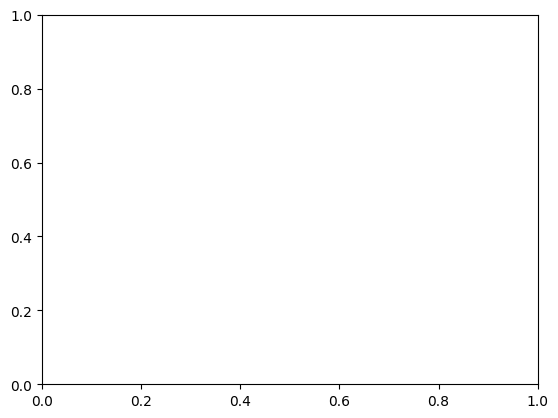

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(compute_target['FinRepScore'],scaled_total_report['fiscalDateEnding'])

## Regression Model Selection Diary

In [ ]:
scaled_total_report = scaled_total_report.iloc[1:].reset_index(drop=True)


In [ ]:
X = scaled_total_report
y = compute_target["FinRepScore"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[5,10,20],
    'max_depth':[None,5,10],
    'min_samples_split':[2,5]
}


# Initialize and train the model
model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Best Params
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 20}
Best MSE: 16.566359785552045


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Insert best params
best = RandomForestRegressor(max_depth=5, min_samples_split=5,n_estimators=20)
best.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=20)

In [ ]:
# Make predictions
y_pred = best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE/Average Score:", mse/compute_target['FinRepScore'].mean())
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

MSE/Average Score: -225.4400671956465
Mean Absolute Error (MAE): 3.715002259386178
R² Score: 0.01972313401825343


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        self.lstm = nn.LSTM()
    

# Export

In [ ]:
#exports model
import joblib
joblib.dump(model,'rf.joblib')

['rf.joblib']

In [ ]:
#loaded_model = joblib.load('rf.joblib')
#loaded.predict(X_Test)